# Part 2 - Alternative Architectures

The purpose of this notebook is to expand upon the first notebook and build some newer style CNN architectures - specifically Residual Blocks and Inception Blocks.

This will be using basically the same code structure as the previous notebook just with different architectures swapped in.

In [7]:
#First importing some relevant packages
import numpy as np
import pandas as pd

#Import Tensorflow
import tensorflow as tf

#Import Keras
import keras
from keras import layers
from keras.layers import Activation, ZeroPadding2D, AveragePooling2D, Add, Concatenate
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input
#from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Sequential, Model
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.initializers import glorot_uniform


#Import general utilities
import os
import gc
import pickle
import itertools

#import sklearn
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Import mathematical functions
from random import *
import math
import matplotlib
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'D:/Datasets/MNIST/'
GENERATED_FOLDER = 'D:/Datasets/MNIST/modeldata/'

In [3]:
train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
X_test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [4]:
Y_full = train["label"]

# Drop 'label' column
X_full = train.drop(labels = ["label"],axis = 1) 

# Normalize the data
X_full = X_full / 255.0
X_test = X_test / 255.0

# Reshape image in 4 dimensions (height = 28px, width = 28px , canal = 1)
X_full = X_full.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

del train

gc.collect()

14

In [5]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_full, Y_full, test_size=0.1)

In [6]:
#Setup data augmentation
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

#Convert Y vectors to categoricals
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

print(Y_Train[1])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Now the data is imported as before now to start with the new parts.  Firstly lets build a simple ResNet model with residual blocks.

## Residual Architectures

As a small primer residual architectures work by adding in 'skip connections'.  This means that after a convolution the original input will be taken and added to the output (if it is a SAME convolution at least).  This has the effect of ensuring that convolutional layers can very easily learn the identity function, meaning that the traditional problem of weight decay/explosion for deeper architectures is significantly mitigated.

As our dataset uses small 28x28 pixel input images there is no need for an incredibly deep ResNet like ResNet101 so instead I will use a modification of of ResNet18 with 2 layer residual blocks of the following sizes of NxN (# of filters) - 

### ResNet 18 Architecture (Original)
1. 7x7 (64) x1 ( + 3x3 s=2 MAXPOOL)
2. 3x3 (64) x 2 RES
3. 3x3 (128) x 2 RES
4. 3x3 (256) x 2 RES
5. 3x3 (512) x 2 RES (+ 2x2 s=2 AVGPOOL)
6. 1000 DENSE
7. SOFTMAX

### Modified ResNet Architecture
1. 7x7 (64) x1 ( + 3x3 s=2 MAXPOOL)
2. 3x3 (64) x 2 RES
3. 3x3 (128) x 2 RES
4. 3x3 (256) x 2 RES (+ 2x2 s=s AVGPOOL)
5. 1000 DENSE
6. SOFTMAX

The deviations from the original implementation are - Removed the final 512 filter layers as the image is too small to convolve further (without modifying the earlier layers to SAME convolutions).

The Batch Normalization layers are also removed as they are implemented in the original version to normalize across each of the colour channels, however as the MNIST dataset is greyscale these are not necessary.

In [63]:
#Simple 2 layer Residual Block with fixed filter/window size
def Residual_Block(X, filters, window, s, block) :
    
    #Define Shortcut layer
    X_shortcut = X
    
    #Conv Layer 1
    X = Conv2D(filters, window, strides = (1,1),padding = 'same', name = 'Conv_block_' + block + '_1',
                   kernel_initializer = glorot_uniform())(X)
    #X = BatchNormalization(name = 'BN_' + block + '_1')(X)
    X = Activation('relu')(X)
    
    #Conv Layer 2
    X = Conv2D(filters, window, strides = (s,s), padding = 'valid', name = 'Conv_block_' + block + '_2',
                   kernel_initializer = glorot_uniform())(X)
    #X = BatchNormalization(name = 'BN_' + block + '_2')(X)
    
    #Shortcut Layer
    X_shortcut = Conv2D(filters, window, strides = (s,s), padding = 'valid', 
                        name = 'Shortcut_block_' + block + '_3', 
                        kernel_initializer = glorot_uniform())(X_shortcut)
    #X_shortcut = BatchNormalization(name = 'BNSC_' + block + '_3')(X_shortcut)
                                    
    #Adding Layers                              
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)   
    
    return X

Now to put the blocks into a full model.

In [64]:
def ResNet_MNIST():
    #Input layer
    X_input = Input((28,28,1))
    
    X = ZeroPadding2D((3, 3))(X_input)

    #Layer 1
    X = Conv2D(64, (7, 7), strides = (1, 1), activation='relu')(X)
    X = MaxPool2D(3, 2)(X)
    
    #Layers 2-5 Residual Blocks
    X = Residual_Block(X, 64, (3,3),s=1, block='a')
    X = Residual_Block(X, 128, (3,3),s=2, block='b')
    X = Residual_Block(X, 256, (3,3),s=2, block='c')
    #X = Residual_Block(X, 512, (3,3),s=2, block='d')

    #Average Pooling
    X = AveragePooling2D()(X)

    #Convert to vector for final dense layers
    X = Flatten()(X)
    
    #Adding final dense layers
    X = Dense(1000, activation='relu')(X)
    
    X = Dense(10, activation='softmax')(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [23]:
start_LR = 0.001
LR_Decay = 0.95

LR_Decayer = LearningRateScheduler(lambda x: start_LR * LR_Decay ** x)

In [67]:
resnet_mod = ResNet_MNIST()
resnet_mod.compile(optimizer = Adam(start_LR), loss = "binary_crossentropy", metrics = ["accuracy"])

In [68]:
hist = resnet_mod.fit_generator(datagen.flow(X_Train, Y_Train, batch_size=64),
                           steps_per_epoch=1000,
                           epochs=30,
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(X_Val[:400,:], Y_Val[:400,:]),
                           callbacks=[LR_Decayer])

Epoch 1/30
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0433 - acc: 0.9852 - val_loss: 0.0115 - val_acc: 0.9972
Epoch 2/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0124 - acc: 0.9961 - val_loss: 0.0167 - val_acc: 0.9952
Epoch 3/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0094 - acc: 0.9970 - val_loss: 0.0123 - val_acc: 0.9960
Epoch 4/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0073 - acc: 0.9977 - val_loss: 0.0120 - val_acc: 0.9967
Epoch 5/30
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0067 - acc: 0.9979 - val_loss: 0.0151 - val_acc: 0.9965
Epoch 6/30
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0058 - acc: 0.9981 - val_loss: 0.0084 - val_acc: 0.9988
Epoch 7/30
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0096 - val_acc: 0.9977
Epoch 8/30
1000/1000 [==========================

In [69]:
final_loss, final_acc = resnet_mod.evaluate(X_Val, Y_Val, verbose=0)

In [70]:
print('Final Validation Loss = ', final_loss)
print('Final Validation Accuracy = ', final_acc)

Final Validation Loss =  0.005316321808003322
Final Validation Accuracy =  0.9993333307902018


So now we have a model let's analyse the errors.

In [71]:
Y_hat_val = resnet_mod.predict(X_Val)

In [72]:
# Convert predictions classes to one hot vectors 
Y_hat_classes = np.argmax(Y_hat_val, axis = 1) 
# Convert validation observations to one hot vectors
Y_val_classes = np.argmax(Y_Val, axis = 1) 

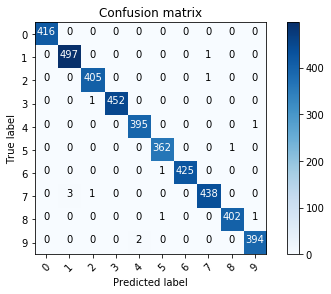

In [73]:
#This code taken almost direct from a source, who attained it from SK Learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val_classes, Y_hat_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

So this when trained on a good number of epochs is a marked improvement at least in validation, despite when trained on fewer epochs being noticably worse.  Let's submit and see how it does.

In [54]:
sample_sub = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

In [74]:
y_out = resnet_mod.predict(X_test)

In [76]:
Y_out_classes = np.argmax(y_out, axis = 1) 
sample_sub['Label'] = Y_out_classes

In [77]:
sample_sub.to_csv('test_mnist_sub.csv', index=False)

As it happened it scored 99.5% which is remarkably close to state of the art performance.  This model architecture probably get a better score with some regularization and basic ensembling, maybe even up to state of the art performance.

However let's move on to the logical evolution of this architecture - Inception Nets.

## Inception Blocks

The motivation for inception blocks is to increase the representational power of each of the residual blocks introduced by ResNet.  In order to do this the initial idea was to utilize multiple different convolutional filters (eg 7x7 and 5x5 and 3x3) and concatenating them together.  However this was later refined to using stacks of 3x3 convolutions as they are more computationally efficient but still have the same representative power.  This was later even further refined by using 1xn and nx1 convolutions and combining multiple different blocks together (see https://arxiv.org/pdf/1602.07261.pdf ).

The key difference to note here is that inception uses concatenations of the different filters for the reductions wheras ResNet uses addition layers.

As this project is relatively small and computationally simple to learn I will stick to a simple implementation of the typical reduction block used in Inception v2 onwards.

I will also use the same stem as I used in the mini-ResNet above as opposed to the deeper stem used in the original paper, equivalently I will also use the same output blocks as the ResNet inspired model, as well as only using 2 Inception blocks (due to dimensionality reduction).  I will also use fewer filters than used in the Inception v4 implementation in order to keep the number of trainable parameters to be roughly comparable.

### Block Used
#### Path 1
1. 3x3 MAXPOOL

#### Path 2
1. 3x3 Conv

#### Path 3
1. 1x1 Conv
2. 3x3 Conv
3. 3x3 Conv

Followed by a concatenation of all of the paths combined.

In [41]:
#Implementation of Reduction Block a from Inception v4
def Inception_Block(X, block) :
    
    #Define Branches
    X_1 = X
    X_2 = X
    X_3 = X
    
    #Branch 1
    X_1 = MaxPool2D(pool_size=(3, 3), strides = 2 , padding='valid')(X_1)

    #Branch 2
    X_2 = Conv2D(256, (3, 3), strides=2, padding='valid', name='Incep_block_' + block + '_b2a')(X_2)
    
    #Branch 3
    X_3 = Conv2D(64, (1, 1), padding='same', name='Incep_block_' + block + '_b3a')(X_3)
    X_3 = Conv2D(96, (3, 3), padding='same', name='Incep_block_' + block + '_b3b')(X_3)
    X_3 = Conv2D(128, (3, 3), strides=2, padding='valid', name='Incep_block_' + block + '_b3c')(X_3)
    
    #Concatenating branches
    X = Concatenate(axis=3)([X_1, X_2, X_3])
    
    #Applying Non-linearity
    X = Activation('relu')(X)   
    
    return X

In [42]:
def Inception_MNIST():
    #Input layer
    X_input = Input((28,28,1))
    
    X = ZeroPadding2D((3, 3))(X_input)

    #Layer 1
    X = Conv2D(64, (7, 7), strides = (1, 1), activation='relu')(X)
    X = MaxPool2D(3, 2)(X)
    
    #Inception Blocks
    X = Inception_Block(X, block='a')
    X = Inception_Block(X, block='b')

    #Average Pooling
    X = AveragePooling2D()(X)

    #Convert to vector for final dense layers
    X = Flatten()(X)
    
    #Adding final dense layers
    X = Dense(1000, activation='relu')(X)
    
    X = Dense(10, activation='softmax')(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [43]:
inception_mod = Inception_MNIST()
inception_mod.compile(optimizer = Adam(start_LR), loss = "binary_crossentropy", metrics = ["accuracy"])

In [46]:
hist2 = inception_mod.fit_generator(datagen.flow(X_Train, Y_Train, batch_size=64),
                           steps_per_epoch=1000,
                           epochs=30,
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(X_Val[:400,:], Y_Val[:400,:]),
                           callbacks=[LR_Decayer])

Epoch 1/30
1000/1000 [==============================] - 58s 58ms/step - loss: 0.0377 - acc: 0.9870 - val_loss: 0.0209 - val_acc: 0.9945
Epoch 2/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0126 - acc: 0.9957 - val_loss: 0.0118 - val_acc: 0.9968
Epoch 3/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0101 - acc: 0.9966 - val_loss: 0.0080 - val_acc: 0.9972
Epoch 4/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0087 - acc: 0.9971 - val_loss: 0.0147 - val_acc: 0.9972
Epoch 5/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0147 - val_acc: 0.9973
Epoch 6/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0072 - acc: 0.9976 - val_loss: 0.0100 - val_acc: 0.9980
Epoch 7/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0062 - acc: 0.9979 - val_loss: 0.0085 - val_acc: 0.9972
Epoch 8/30
1000/1000 [==========================

In [47]:
incep_loss, incep_acc = inception_mod.evaluate(X_Val, Y_Val, verbose=0)

In [48]:
print('Final Validation Loss = ', incep_loss)
print('Final Validation Accuracy = ', incep_acc)

Final Validation Loss =  0.005637252022734878
Final Validation Accuracy =  0.9987142826261974


In [50]:
Y_hat_val = inception_mod.predict(X_Val)

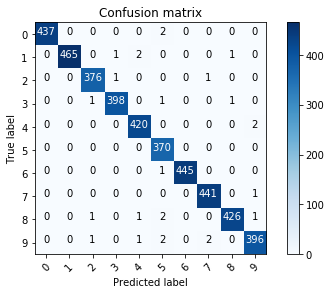

In [53]:
# Convert predictions classes to one hot vectors 
Y_hat_classes = np.argmax(Y_hat_val, axis = 1) 
# Convert validation observations to one hot vectors
Y_val_classes = np.argmax(Y_Val, axis = 1) 
    
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val_classes, Y_hat_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

This has very very comparable performance to the ResNet model implemented previously, so let's see how it does on submission.

In [55]:
y_out = inception_mod.predict(X_test)

In [57]:
Y_out_classes = np.argmax(y_out, axis = 1) 
sample_sub['Label'] = Y_out_classes

In [58]:
sample_sub.to_csv('test_mnist_sub.csv', index=False)

As the validation shown this model had very similar performance to the ResNet inspired model but just slightly behind with a score of 99.4%.  This is likely attributable to the fact this network has 1 less block, however this is within the margin for error so for all intents and purposes the models are effectively equivalent.


Overall from this notebook I am confident in accurately implementing extensions of the above architectures for larger and more advanced challenges, so with that I am very happy with how this went.

For fun below is a log of every submission I made along with the model architecture summaries.

##  Test Submissions

#### Batch Size = 8, Images per epoch = 500
* ResNet(No BN, 10 epochs) = 0.97814
* ResNet (With BN, 10 epochs) = 0.97357

### Batch Size = 64, Images per epoch = 1000
* ResNet (No BN, 30 epochs) = 0.99514
* Inception (30 epochs) = 0.99471


In [78]:
resnet_mod.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 34, 34, 1)    0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 64)   3200        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 13, 13, 64)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
Conv_block

In [56]:
inception_mod.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 34, 34, 1)    0           input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 64)   3200        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 13, 13, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
Incep_bloc